# Notebook 2: Functional Fields

**Part 2 of the GRL Field Series**

---

## Overview

In Notebook 1, we saw **vector fields** — arrows at each point. Now we take the conceptual leap to **functional fields**, where each point is associated with a **function** (an infinite-dimensional vector).

This is the mathematical foundation of GRL's reinforcement field.

### Learning Objectives

1. **Functions as vectors** — Addition, scaling, inner products
2. **Kernel functions** — Measuring similarity between points
3. **RKHS intuition** — Reproducing Kernel Hilbert Space
4. **Functional gradients** — Optimization in function space
5. **Bridge to GRL** — How particles create the reinforcement field

### Prerequisites

- Notebook 1 (Classical Vector Fields)
- Basic linear algebra (vectors, inner products)

### Time

~25-30 minutes

In [17]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

INTERACTIVE = False
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline
print(f"Libraries loaded. Interactive: {INTERACTIVE and WIDGETS_AVAILABLE}")

Libraries loaded. Interactive: False


---
## Part 1: Functions as Vectors

### The Key Insight

Functions can be treated as **vectors** in an infinite-dimensional space!

| Operation | Finite Vectors | Functions |
|-----------|----------------|----------|
| **Addition** | $\mathbf{u} + \mathbf{v}$ | $(f + g)(x) = f(x) + g(x)$ |
| **Scaling** | $c \cdot \mathbf{u}$ | $(cf)(x) = c \cdot f(x)$ |
| **Inner Product** | $\mathbf{u} \cdot \mathbf{v} = \sum_i u_i v_i$ | $\langle f, g \rangle = \int f(x) g(x) dx$ |
| **Norm** | $\|\mathbf{u}\| = \sqrt{\mathbf{u} \cdot \mathbf{u}}$ | $\|f\| = \sqrt{\langle f, f \rangle}$ |

### Why This Matters for GRL

In GRL, the reinforcement field $Q^+$ is a **function** (a vector in function space). Operations like "adding experience" become vector addition in this space.

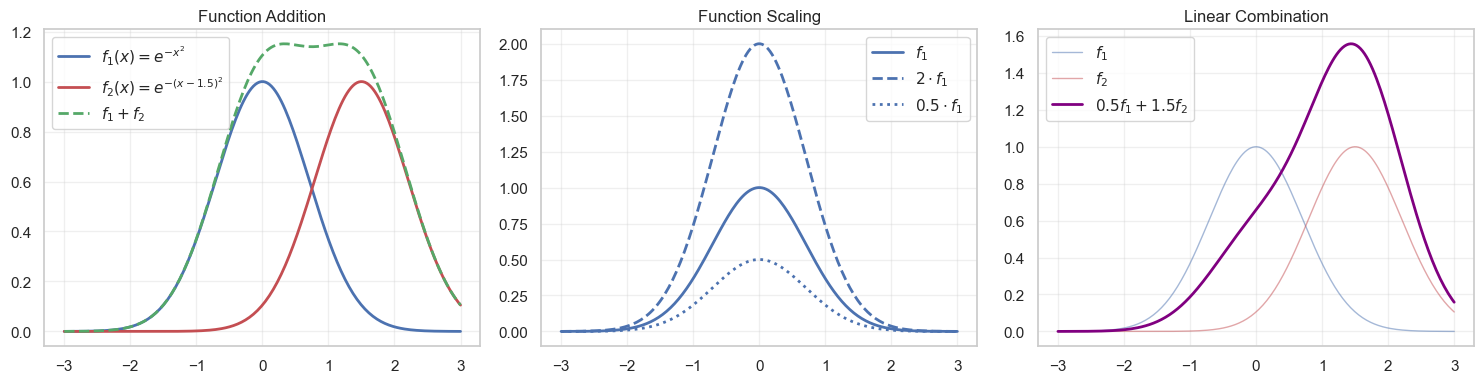

Functions behave like vectors: we can add them and scale them!


In [18]:
# Example 1.1: Functions as Vectors — Addition and Scaling
x = np.linspace(-3, 3, 200)

# Define two "basis" functions
f1 = np.exp(-x**2)           # Gaussian centered at 0
f2 = np.exp(-(x-1.5)**2)     # Gaussian centered at 1.5

# Linear combinations (just like vectors!)
f_sum = f1 + f2              # Addition
f_scaled = 2 * f1            # Scaling
f_combo = 0.5 * f1 + 1.5 * f2  # General linear combination

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Addition
axes[0].plot(x, f1, 'b-', lw=2, label=r'$f_1(x) = e^{-x^2}$')
axes[0].plot(x, f2, 'r-', lw=2, label=r'$f_2(x) = e^{-(x-1.5)^2}$')
axes[0].plot(x, f_sum, 'g--', lw=2, label=r'$f_1 + f_2$')
axes[0].set_title('Function Addition'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Scaling
axes[1].plot(x, f1, 'b-', lw=2, label=r'$f_1$')
axes[1].plot(x, f_scaled, 'b--', lw=2, label=r'$2 \cdot f_1$')
axes[1].plot(x, 0.5*f1, 'b:', lw=2, label=r'$0.5 \cdot f_1$')
axes[1].set_title('Function Scaling'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Linear combination
axes[2].plot(x, f1, 'b-', lw=1, alpha=0.5, label=r'$f_1$')
axes[2].plot(x, f2, 'r-', lw=1, alpha=0.5, label=r'$f_2$')
axes[2].plot(x, f_combo, 'purple', lw=2, label=r'$0.5 f_1 + 1.5 f_2$')
axes[2].set_title('Linear Combination'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()
print("Functions behave like vectors: we can add them and scale them!")

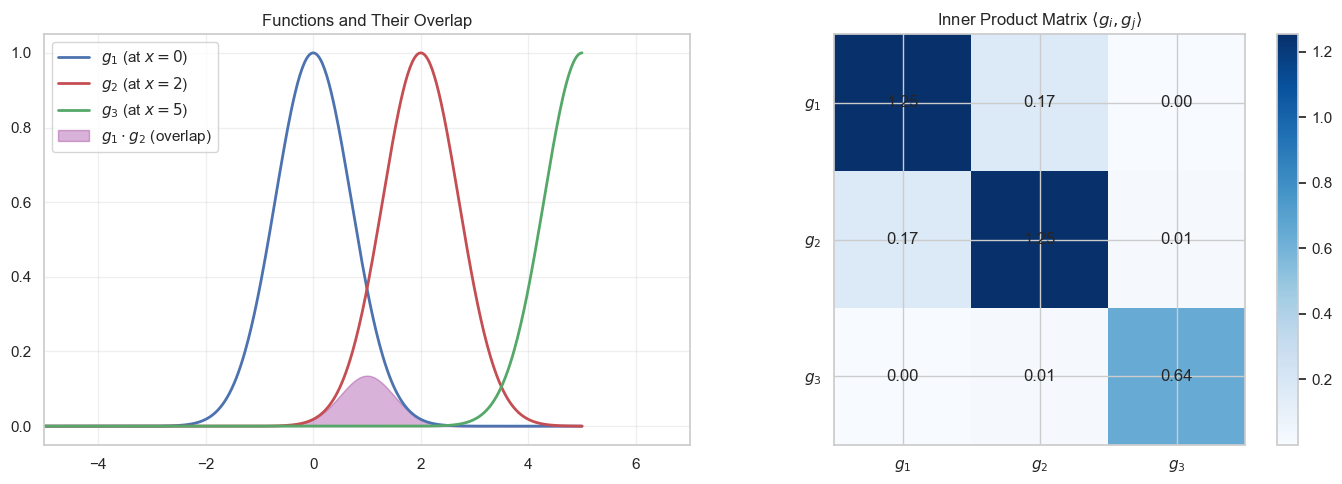

Inner products: <g1,g1>=1.25, <g1,g2>=0.17, <g1,g3>=0.0000
Large overlap → large inner product. Little overlap → small inner product.


In [19]:
# Example 1.2: Inner Products on Functions
# Inner product: <f, g> = ∫ f(x) g(x) dx

def inner_product(f, g, x):
    """Approximate inner product via numerical integration"""
    dx = x[1] - x[0]
    return np.sum(f * g) * dx

x = np.linspace(-5, 5, 500)

# Three functions
g1 = np.exp(-x**2)           # Gaussian at 0
g2 = np.exp(-(x-2)**2)       # Gaussian at 2 (some overlap)
g3 = np.exp(-(x-5)**2)       # Gaussian at 5 (little overlap)

# Compute inner products
ip_11 = inner_product(g1, g1, x)  # <g1, g1> = ||g1||²
ip_12 = inner_product(g1, g2, x)  # <g1, g2> — some overlap
ip_13 = inner_product(g1, g3, x)  # <g1, g3> — little overlap

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot functions
ax1 = axes[0]
ax1.plot(x, g1, 'b-', lw=2, label=r'$g_1$ (at $x=0$)')
ax1.plot(x, g2, 'r-', lw=2, label=r'$g_2$ (at $x=2$)')
ax1.plot(x, g3, 'g-', lw=2, label=r'$g_3$ (at $x=5$)')
ax1.fill_between(x, 0, g1*g2, alpha=0.3, color='purple', label=r'$g_1 \cdot g_2$ (overlap)')
ax1.set_title('Functions and Their Overlap')
ax1.legend(); ax1.grid(True, alpha=0.3); ax1.set_xlim(-5, 7)

# Inner product matrix
ax2 = axes[1]
ip_matrix = np.array([[ip_11, ip_12, ip_13],
                      [ip_12, inner_product(g2,g2,x), inner_product(g2,g3,x)],
                      [ip_13, inner_product(g2,g3,x), inner_product(g3,g3,x)]])
im = ax2.imshow(ip_matrix, cmap='Blues')
ax2.set_xticks([0,1,2]); ax2.set_yticks([0,1,2])
ax2.set_xticklabels([r'$g_1$', r'$g_2$', r'$g_3$'])
ax2.set_yticklabels([r'$g_1$', r'$g_2$', r'$g_3$'])
for i in range(3):
    for j in range(3):
        ax2.text(j, i, f'{ip_matrix[i,j]:.2f}', ha='center', va='center', fontsize=12)
ax2.set_title(r'Inner Product Matrix $\langle g_i, g_j \rangle$')
plt.colorbar(im, ax=ax2)

plt.tight_layout(); plt.show()
print(f"Inner products: <g1,g1>={ip_11:.2f}, <g1,g2>={ip_12:.2f}, <g1,g3>={ip_13:.4f}")
print("Large overlap → large inner product. Little overlap → small inner product.")

---
## Part 2: Kernel Functions — Similarity in Function Space

### What is a Kernel?

A **kernel function** $k(x, x')$ measures similarity between two points:

$$k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$$

### The RBF (Gaussian) Kernel

The most common kernel is the **Radial Basis Function (RBF)** kernel:

$$k(x, x') = \exp\left(-\frac{\|x - x'\|^2}{2\ell^2}\right)$$

where $\ell$ is the **lengthscale** parameter.

**Properties:**
- $k(x, x) = 1$ (self-similarity is maximal)
- $k(x, x') \to 0$ as $\|x - x'\| \to \infty$ (distant points are dissimilar)
- $\ell$ controls the "range of influence"

### Connection to RKHS

The kernel defines an **implicit feature map** $\phi(x)$ such that:

$$k(x, x') = \langle \phi(x), \phi(x') \rangle$$

The kernel IS the inner product in feature space!

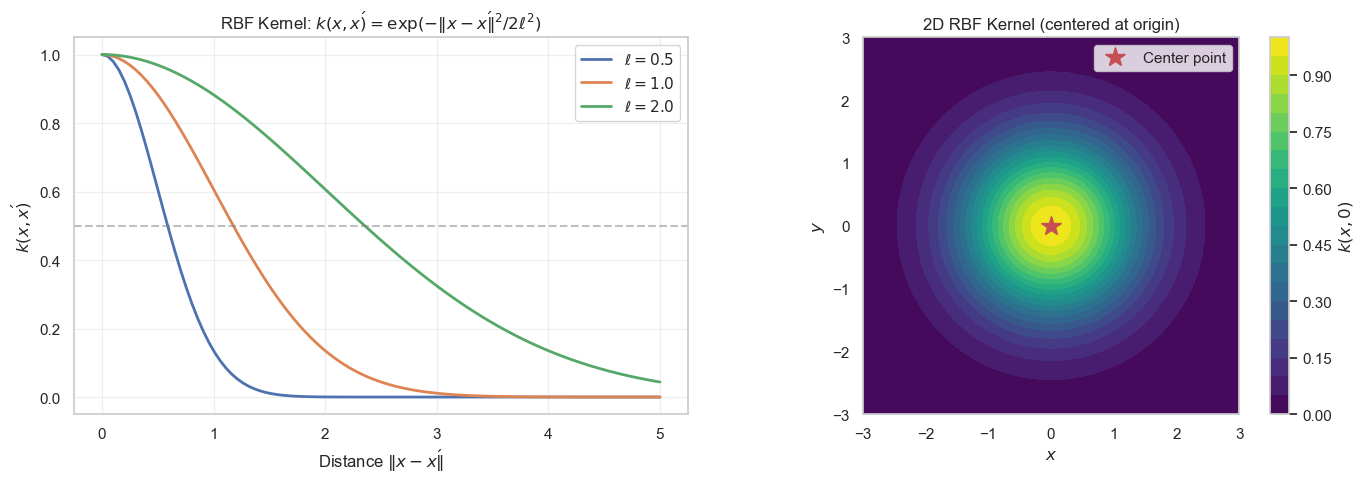

Kernel = similarity measure. Large ℓ → wider influence. Small ℓ → local influence.


In [20]:
# Example 2.1: RBF Kernel Visualization
def rbf_kernel(x, x_prime, lengthscale=1.0):
    """RBF (Gaussian) kernel: k(x, x') = exp(-||x-x'||² / 2ℓ²)"""
    return np.exp(-np.sum((x - x_prime)**2) / (2 * lengthscale**2))

def rbf_kernel_matrix(X, lengthscale=1.0):
    """Compute kernel matrix K_ij = k(x_i, x_j)"""
    n = len(X)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = rbf_kernel(X[i], X[j], lengthscale)
    return K

# Visualize kernel as a function of distance
distances = np.linspace(0, 5, 100)
lengthscales = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Kernel vs distance for different lengthscales
ax1 = axes[0]
for l in lengthscales:
    k_vals = np.exp(-distances**2 / (2 * l**2))
    ax1.plot(distances, k_vals, lw=2, label=rf'$\ell = {l}$')
ax1.set_xlabel(r'Distance $\|x - x\'\|$')
ax1.set_ylabel(r'$k(x, x\')$')
ax1.set_title(r'RBF Kernel: $k(x, x\') = \exp(-\|x-x\'\|^2 / 2\ell^2)$')
ax1.legend(); ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Right: 2D kernel heatmap
ax2 = axes[1]
x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
# Kernel centered at (0, 0)
K_2d = np.exp(-(X**2 + Y**2) / (2 * 1.0**2))
im = ax2.contourf(X, Y, K_2d, levels=20, cmap='viridis')
ax2.plot(0, 0, 'r*', markersize=15, label='Center point')
ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$')
ax2.set_title('2D RBF Kernel (centered at origin)')
ax2.set_aspect('equal'); ax2.legend()
plt.colorbar(im, ax=ax2, label='$k(x, 0)$')

plt.tight_layout(); plt.show()
print("Kernel = similarity measure. Large ℓ → wider influence. Small ℓ → local influence.")

---
## Part 3: From Kernels to Fields — The GRL Connection

### The Key Equation

In GRL, the reinforcement field is built from **particles** using kernels:

$$Q^+(z) = \sum_{i=1}^{N} w_i \, k(z, z_i)$$

where:
- $z = (s, \theta)$ is a point in augmented state-action space
- $(z_i, w_i)$ are experience particles with positions and weights
- $k(z, z_i)$ is the kernel (e.g., RBF)

### Interpretation

Each particle creates a **"bump"** in the field:
- **Positive weight** ($w_i > 0$): Creates a peak (good region)
- **Negative weight** ($w_i < 0$): Creates a valley (bad region)

The total field is the **superposition** of all bumps — exactly like we saw in Notebook 1!

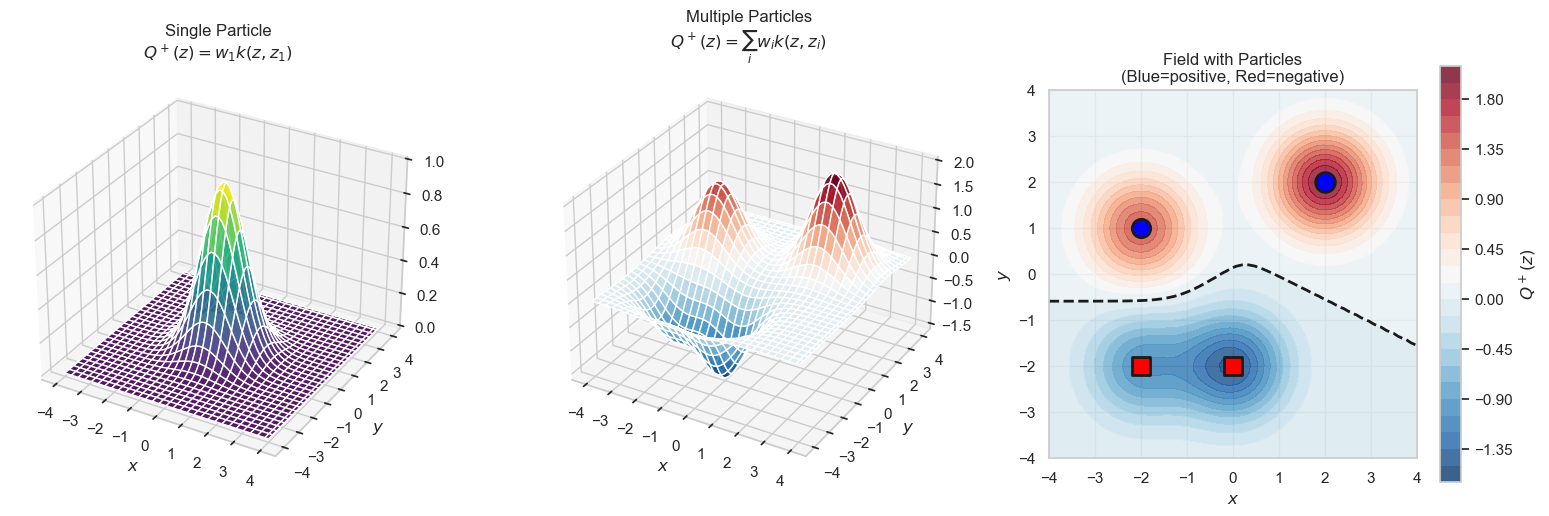

Each particle creates a 'bump'. The field is their superposition.
This is EXACTLY how GRL represents the value function!


In [21]:
# Example 3.1: Building a Field from Particles
def build_field(X, Y, particles, lengthscale=0.8):
    """Build Q⁺ field from particles: Q⁺(z) = Σᵢ wᵢ k(z, zᵢ)"""
    Z = np.zeros_like(X)
    for p in particles:
        r2 = (X - p['x'])**2 + (Y - p['y'])**2
        Z += p['w'] * np.exp(-r2 / (2 * lengthscale**2))
    return Z

# Create grid
x = np.linspace(-4, 4, 60)
y = np.linspace(-4, 4, 60)
X, Y = np.meshgrid(x, y)

# Single particle
single = [{'x': 0, 'y': 0, 'w': 1.0}]
Z_single = build_field(X, Y, single)

# Multiple particles
multi = [
    {'x': 2, 'y': 2, 'w': 2.0},     # Strong positive
    {'x': -2, 'y': 1, 'w': 1.5},    # Positive
    {'x': 0, 'y': -2, 'w': -1.5},   # Negative
    {'x': -2, 'y': -2, 'w': -1.0},  # Negative
]
Z_multi = build_field(X, Y, multi)

fig = plt.figure(figsize=(16, 5))

# Single particle
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z_single, cmap='viridis', alpha=0.9)
ax1.set_title('Single Particle\n$Q^+(z) = w_1 k(z, z_1)$')
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$')

# Multiple particles - 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, Z_multi, cmap='RdBu_r', alpha=0.9)
ax2.set_title(r'Multiple Particles' + '\n' + r'$Q^+(z) = \sum_i w_i k(z, z_i)$')
ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$')

# Multiple particles - 2D with particles marked
ax3 = fig.add_subplot(133)
c = ax3.contourf(X, Y, Z_multi, levels=25, cmap='RdBu_r', alpha=0.8)
ax3.contour(X, Y, Z_multi, levels=[0], colors='k', linewidths=2, linestyles='--')
for p in multi:
    color = 'blue' if p['w'] > 0 else 'red'
    marker = 'o' if p['w'] > 0 else 's'
    size = 100 + 50 * abs(p['w'])
    ax3.scatter(p['x'], p['y'], c=color, s=size, marker=marker, edgecolors='k', linewidths=2)
ax3.set_title('Field with Particles\n(Blue=positive, Red=negative)')
ax3.set_xlabel('$x$'); ax3.set_ylabel('$y$'); ax3.set_aspect('equal')
plt.colorbar(c, ax=ax3, label='$Q^+(z)$')

plt.tight_layout(); plt.show()
print("Each particle creates a 'bump'. The field is their superposition.")
print("This is EXACTLY how GRL represents the value function!")

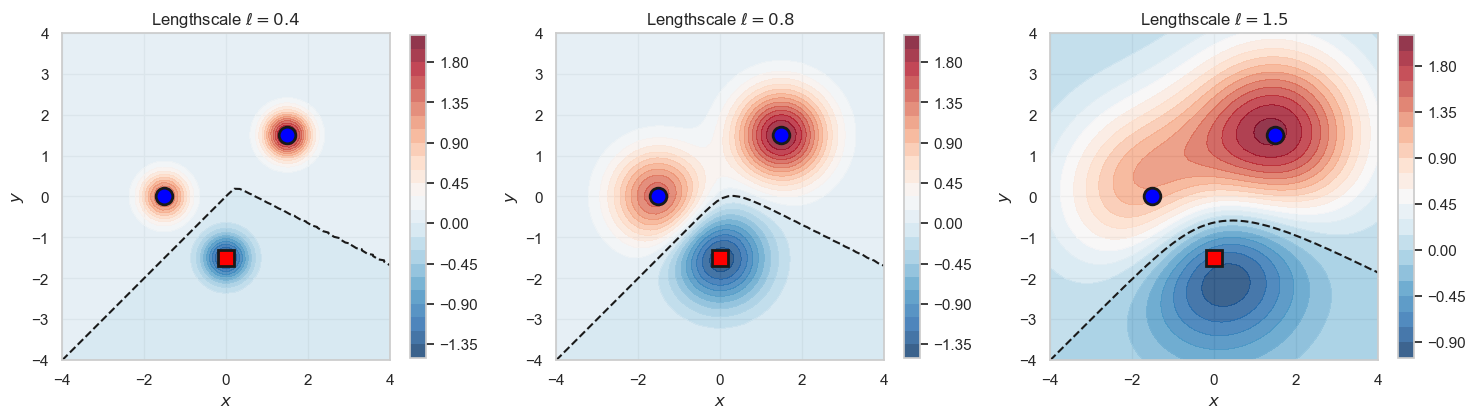

Small ℓ: Sharp, localized bumps. Large ℓ: Smooth, spread-out influence.
In GRL, ℓ controls how far each experience 'spreads' its influence.


In [22]:
# Example 3.2: Effect of Lengthscale
particles = [
    {'x': 1.5, 'y': 1.5, 'w': 2.0},
    {'x': -1.5, 'y': 0, 'w': 1.5},
    {'x': 0, 'y': -1.5, 'w': -1.5},
]

lengthscales = [0.4, 0.8, 1.5]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, l in zip(axes, lengthscales):
    Z = build_field(X, Y, particles, lengthscale=l)
    c = ax.contourf(X, Y, Z, levels=25, cmap='RdBu_r', alpha=0.8)
    ax.contour(X, Y, Z, levels=[0], colors='k', linewidths=1.5, linestyles='--')
    for p in particles:
        color = 'blue' if p['w'] > 0 else 'red'
        ax.plot(p['x'], p['y'], 'o' if p['w']>0 else 's', color=color, ms=12, mec='k', mew=2)
    ax.set_title(rf'Lengthscale $\ell = {l}$')
    ax.set_xlabel('$x$'); ax.set_ylabel('$y$'); ax.set_aspect('equal')
    plt.colorbar(c, ax=ax, shrink=0.8)

plt.tight_layout(); plt.show()
print("Small ℓ: Sharp, localized bumps. Large ℓ: Smooth, spread-out influence.")
print("In GRL, ℓ controls how far each experience 'spreads' its influence.")

---
## Part 4: Functional Gradients

### Gradient of the Field

The gradient of $Q^+$ tells us the direction of improvement:

$$\nabla Q^+(z) = \sum_{i=1}^{N} w_i \nabla_z k(z, z_i)$$

For the RBF kernel:

$$\nabla_z k(z, z_i) = -\frac{z - z_i}{\ell^2} k(z, z_i)$$

### Policy from Gradient

In GRL, the agent can improve its action by following the gradient:

$$a_{\text{better}} = a + \eta \nabla_a Q^+(s, a)$$

This is how policy emerges from the field!

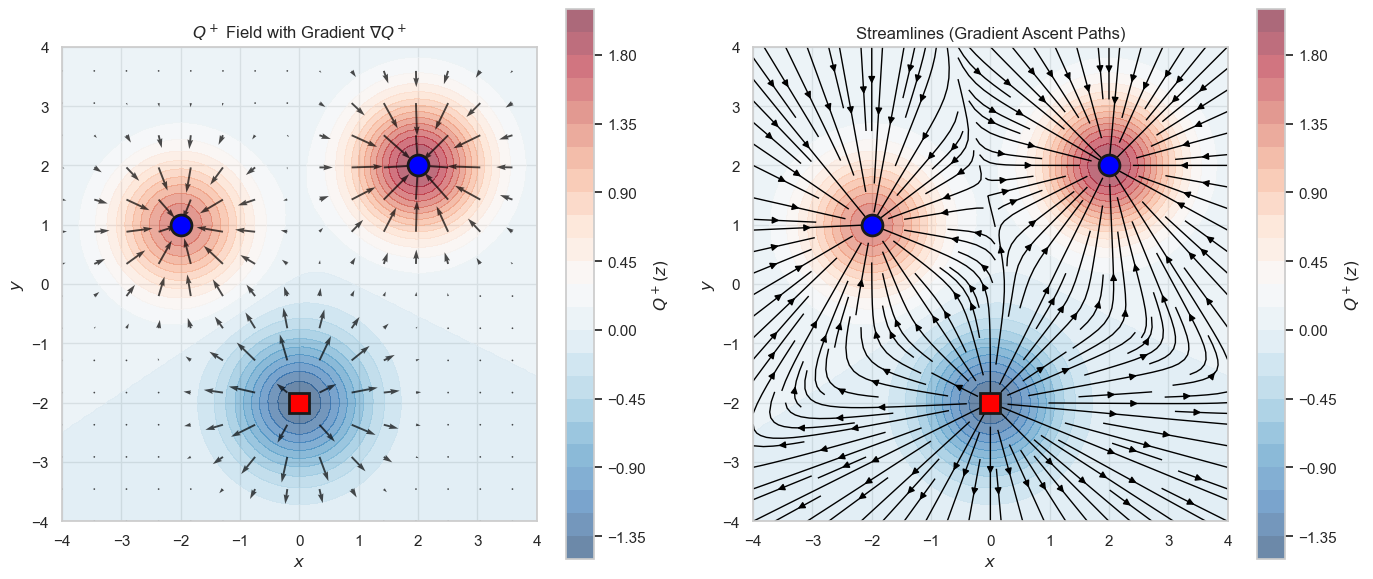

Gradient points toward positive particles (good) and away from negative (bad).
Following the gradient = improving the action = GRL's policy!


In [23]:
# Example 4.1: Gradient Field Visualization
def build_gradient(X, Y, particles, lengthscale=0.8):
    """Compute gradient of Q⁺: ∇Q⁺ = Σᵢ wᵢ ∇k(z, zᵢ)"""
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for p in particles:
        dx, dy = X - p['x'], Y - p['y']
        r2 = dx**2 + dy**2
        k = np.exp(-r2 / (2 * lengthscale**2))
        factor = -p['w'] / (lengthscale**2)
        U += factor * dx * k
        V += factor * dy * k
    return U, V

# Particles
particles = [
    {'x': 2, 'y': 2, 'w': 2.0},
    {'x': -2, 'y': 1, 'w': 1.5},
    {'x': 0, 'y': -2, 'w': -1.5},
]

Z = build_field(X, Y, particles)
U, V = build_gradient(X, Y, particles)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Field with gradient arrows
ax1 = axes[0]
c = ax1.contourf(X, Y, Z, levels=25, cmap='RdBu_r', alpha=0.6)
skip = 4
ax1.quiver(X[::skip,::skip], Y[::skip,::skip], U[::skip,::skip], V[::skip,::skip],
           color='black', alpha=0.7, scale=20)
for p in particles:
    color = 'blue' if p['w'] > 0 else 'red'
    ax1.plot(p['x'], p['y'], 'o' if p['w']>0 else 's', color=color, ms=15, mec='k', mew=2)
ax1.set_title(r'$Q^+$ Field with Gradient $\nabla Q^+$')
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$'); ax1.set_aspect('equal')
plt.colorbar(c, ax=ax1, label='$Q^+(z)$')

# Streamlines
ax2 = axes[1]
c2 = ax2.contourf(X, Y, Z, levels=25, cmap='RdBu_r', alpha=0.6)
ax2.streamplot(X, Y, U, V, color='black', density=1.5, linewidth=1)
for p in particles:
    color = 'blue' if p['w'] > 0 else 'red'
    ax2.plot(p['x'], p['y'], 'o' if p['w']>0 else 's', color=color, ms=15, mec='k', mew=2)
ax2.set_title('Streamlines (Gradient Ascent Paths)')
ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$'); ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2, label='$Q^+(z)$')

plt.tight_layout(); plt.show()
print("Gradient points toward positive particles (good) and away from negative (bad).")
print("Following the gradient = improving the action = GRL's policy!")

---
## Part 5: The RKHS Perspective

### What is RKHS?

A **Reproducing Kernel Hilbert Space (RKHS)** is a function space where:

1. Functions can be added and scaled (vector space)
2. There's an inner product (Hilbert space)
3. **Evaluation is continuous**: $f(x) = \langle f, k(x, \cdot) \rangle$

### The Reproducing Property

The kernel "reproduces" function values:

$$f(x) = \langle f, k(x, \cdot) \rangle_{\mathcal{H}_k}$$

And importantly:

$$k(x, x') = \langle k(x, \cdot), k(x', \cdot) \rangle_{\mathcal{H}_k}$$

**The kernel IS the inner product between feature representations!**

### Why This Matters

In GRL:
- $Q^+ = \sum_i w_i k(z_i, \cdot)$ is a vector in RKHS
- Each particle contributes a basis function $k(z_i, \cdot)$
- The field is a linear combination of these basis functions
- All operations (evaluation, gradient, update) are well-defined

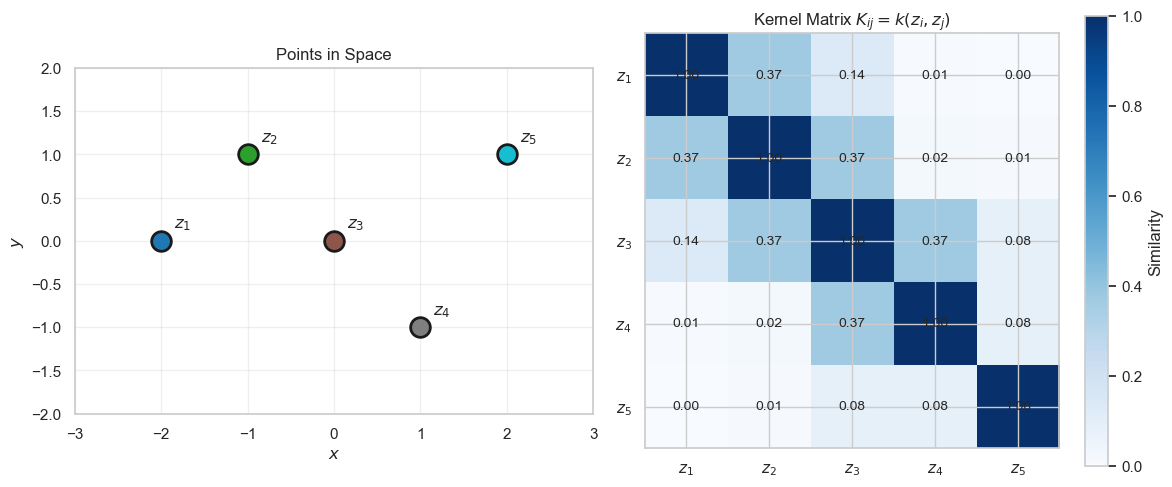

Kernel matrix = similarity matrix = inner products in feature space.
Diagonal = 1 (self-similarity). Off-diagonal = similarity between points.


In [24]:
# Example 5.1: Kernel as Inner Product
# k(x, x') = <φ(x), φ(x')> where φ is the feature map

# For RBF kernel, the feature map is infinite-dimensional!
# But we can visualize the kernel matrix as a "similarity matrix"

# Sample points
np.random.seed(42)
points = np.array([[-2, 0], [-1, 1], [0, 0], [1, -1], [2, 1]])
n = len(points)

# Compute kernel matrix
K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = np.exp(-np.sum((points[i] - points[j])**2) / (2 * 1.0**2))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Points in space
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, n))
for i, (p, c) in enumerate(zip(points, colors)):
    ax1.scatter(p[0], p[1], c=[c], s=200, edgecolors='k', linewidths=2, zorder=5)
    ax1.annotate(f'$z_{i+1}$', (p[0]+0.15, p[1]+0.15), fontsize=12)
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$')
ax1.set_title('Points in Space')
ax1.set_xlim(-3, 3); ax1.set_ylim(-2, 2); ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Kernel matrix
ax2 = axes[1]
im = ax2.imshow(K, cmap='Blues', vmin=0, vmax=1)
ax2.set_xticks(range(n)); ax2.set_yticks(range(n))
ax2.set_xticklabels([f'$z_{i+1}$' for i in range(n)])
ax2.set_yticklabels([f'$z_{i+1}$' for i in range(n)])
for i in range(n):
    for j in range(n):
        ax2.text(j, i, f'{K[i,j]:.2f}', ha='center', va='center', fontsize=10)
ax2.set_title(r'Kernel Matrix $K_{ij} = k(z_i, z_j)$')
plt.colorbar(im, ax=ax2, label='Similarity')

plt.tight_layout(); plt.show()
print("Kernel matrix = similarity matrix = inner products in feature space.")
print("Diagonal = 1 (self-similarity). Off-diagonal = similarity between points.")

---
## Summary: From Vectors to Functions to GRL

### The Progression

| Concept | Classical Vectors | Functions in RKHS | GRL |
|---------|-------------------|-------------------|-----|
| **Element** | Arrow $\mathbf{v}$ | Function $f(\cdot)$ | Field $Q^+(\cdot)$ |
| **Basis** | $\mathbf{e}_1, \mathbf{e}_2, ...$ | $k(z_1, \cdot), k(z_2, \cdot), ...$ | Particle kernels |
| **Representation** | $\mathbf{v} = \sum_i v_i \mathbf{e}_i$ | $f = \sum_i w_i k(z_i, \cdot)$ | $Q^+ = \sum_i w_i k(z_i, \cdot)$ |
| **Inner Product** | $\mathbf{u} \cdot \mathbf{v}$ | $\langle f, g \rangle_{\mathcal{H}}$ | $k(z, z')$ |
| **Gradient** | $\nabla V$ | $\nabla_f J[f]$ | $\nabla Q^+$ |

### Key Equations

**RBF Kernel:**
$$k(z, z') = \exp\left(-\frac{\|z - z'\|^2}{2\ell^2}\right)$$

**Reinforcement Field:**
$$Q^+(z) = \sum_{i=1}^{N} w_i \, k(z, z_i)$$

**Gradient:**
$$\nabla Q^+(z) = \sum_{i=1}^{N} w_i \nabla_z k(z, z_i) = -\sum_{i=1}^{N} \frac{w_i}{\ell^2} (z - z_i) k(z, z_i)$$

### What's Next?

In **Notebook 3**, we'll apply these concepts to a **2D navigation domain** and see how GRL's reinforcement field guides an agent to find optimal paths!